In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots

In [2]:
@model function lar_model(n, order, artype, c)

    x = randomvar(n)
    y = randomvar(n)
    aux = randomvar(n)
    o = datavar(Float64, n)
    ct  = constvar(c)

    γ ~ GammaShapeRate(1.0, 1e-5) where {q=MeanField()}
    θ ~ MvNormalMeanPrecision(randn(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}
    x0 ~ MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)) where {q=MeanField()}

    x_prev = x0

    ar_nodes = Vector{FactorNode}(undef, n)

    for i in 1:n
        ar_nodes[i], x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = ARMeta(artype, order, ARsafe()) }

        y[i] ~ dot(ct, x[i])
        aux[i] ~ NormalMeanVariance(0.0, 1e-12) where {q=MeanField()}
        o[i] ~ NormalMeanVariance(y[i] + aux[i], 1e-12)

        x_prev = x[i]
    end

    return x, θ, o, γ, ar_nodes
end

lar_model (generic function with 1 method)

In [3]:
function lar_inference(data, order, niter)
    n = length(data)
    artype = Multivariate
    c = zeros(order); c[1] = 1.0
    model, (x, θ, o, γ, ar_nodes) = lar_model(n, order, artype, c)

    γ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(getmarginals(x), (mx) -> copyto!(x_buffer, mx))
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))

    setmarginal!(γ, GammaShapeRate(1.0, 1e-12))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)))

    for i in 1:n
        setmarginal!(ar_nodes[i], :y_x, MvNormalMeanPrecision(zeros(2*order), Matrix{Float64}(I, 2*order, 2*order)))
    end
    for i in 1:niter
        update!(o, data)
    end
    return γ_buffer, θ_buffer, x_buffer, fe
end

lar_inference (generic function with 1 method)

In [4]:
@model function coupled_model(n, prior_η, prior_τ, order_1, order_2, artype, c1, c2)

    # z for ar_1
    z  = randomvar(n)
    z1 = randomvar(n)
    # x for ar_2
    x  = randomvar(n)
    x1 = randomvar(n)
    o = datavar(Float64, n)
    
    ct1  = constvar(c1)
    ct2  = constvar(c2)
    
    # AR_1
    γ ~ GammaShapeRate(1.0, 1e-5) where {q=MeanField()}
    θ ~ MvNormalMeanPrecision(zeros(order_1), Matrix{Float64}(I, order_1, order_1)) where {q=MeanField()}
    z0 ~ MvNormalMeanPrecision(zeros(order_1), Matrix{Float64}(I, order_1, order_1)) where {q=MeanField()}
    
    # AR_2
    τ ~ GammaShapeRate(prior_τ[1], prior_τ[2]) where {q=MeanField()}
    η ~ MvNormalMeanPrecision(prior_η[1], prior_η[2]) where {q=MeanField()}
    x0 ~ MvNormalMeanPrecision(zeros(order_2), Matrix{Float64}(I, order_2, order_2)) where {q=MeanField()}

    z_prev = z0
    x_prev = x0

    ar_1_nodes = Vector{FactorNode}(undef, n)
    ar_2_nodes = Vector{FactorNode}(undef, n)

    for i in 1:n
        ar_1_nodes[i], z[i] ~ AR(z_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = ARMeta(artype, order_1, ARsafe()) }
        z1[i] ~ dot(ct1, z[i])
        
        ar_2_nodes[i], x[i] ~ AR(x_prev, η, τ) where { q = q(y, x)q(γ)q(θ), meta = ARMeta(artype, order_2, ARsafe()) }
        x1[i] ~ dot(ct2, x[i])
        
        o[i] ~ NormalMeanVariance(z1[i] + x1[i], 1e-12)

        x_prev = x[i]
        z_prev = z[i]
    end

    return o, x, θ, γ, z, η, τ, ar_1_nodes, ar_2_nodes
end

coupled_model (generic function with 1 method)

In [59]:
function coupled_inference(data, prior_η, prior_τ, order_1, order_2, niter)
    n = length(data)
    artype = Multivariate
    c1 = zeros(order_1); c1[1] = 1.0
    c2 = zeros(order_2); c2[1] = 1.0
    model, (o, x, θ, γ, z, η, τ, ar_1_nodes, ar_2_nodes) = coupled_model(n, prior_η, prior_τ, order_1, order_2, artype, c1, c2, options=(limit_stack_depth=100, ))

    γ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    
    τ_buffer = nothing
    η_buffer = nothing
    z_buffer = Vector{Marginal}(undef, n)
    fe = Vector{Float64}()

    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(getmarginals(x), (mx) -> copyto!(x_buffer, mx))
    
    τsub = subscribe!(getmarginal(τ), (mτ) -> τ_buffer = mτ)
    ηsub = subscribe!(getmarginal(η), (mη) -> η_buffer = mη)
    zsub = subscribe!(getmarginals(z), (mz) -> copyto!(z_buffer, mz))
    
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))
    setmarginal!(γ, GammaShapeRate(1.0, 1e-12))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order_1), Matrix{Float64}(I, order_1, order_1)))
    
    setmarginal!(τ, GammaShapeRate(prior_τ[1], prior_τ[2]))
    setmarginal!(η, MvNormalMeanPrecision(prior_η[1], Matrix{Float64}(I, order_2, order_2)))

    for i in 1:n
        setmarginal!(ar_1_nodes[i], :y_x, MvNormalMeanPrecision(zeros(2*order_1), Matrix{Float64}(I, 2*order_1, 2*order_1)))
        setmarginal!(ar_2_nodes[i], :y_x, MvNormalMeanPrecision(zeros(2*order_2), Matrix{Float64}(I, 2*order_2, 2*order_2)))
    end
    for i in 1:niter
        update!(o, data)
    end
    return γ_buffer, θ_buffer, x_buffer, τ_buffer, η_buffer, z_buffer, fe
end

coupled_inference (generic function with 1 method)

In [60]:
# splitting signal into frames
function get_frames(signal, fs; len_sec=0.01, overlap_sec=0.0025)
    start = 1
    l = Int(round(len_sec*fs))
    overlap = Int(round(overlap_sec*fs))
    totseg = Int(ceil(length(signal)/(l-overlap)))
    segment = zeros(totseg, l)
    for i in 1:totseg - 1
        segment[i,1:l]=signal[start:start+l-1]
        start = (l-overlap)*i+1
    end
    segment[totseg, 1:length(signal)-start+1] = signal[start:length(signal)]
    return segment
end

get_frames (generic function with 1 method)

In [61]:
# Reconstructing the signal
function get_signal(frames, fs; len_sec=0.01, overlap_sec=0.0025)
    l = Int(len_sec*fs)
    overlap = Int(round(overlap_sec*fs))
    totseg = size(frames, 1)
    signal_len = Int(round(totseg * (l - overlap)))
    signal = zeros(signal_len)
    signal[1:l] = frames[1, 1:l]
    start = l + 1
    for i in 2:totseg
        signal[start:start+l-1-overlap]  = frames[i,overlap+1:end]
        start = start + l - overlap - 1
    end
    signal
end

get_signal (generic function with 1 method)

In [62]:
@marginalrule typeof(+)(:in1_in2) (m_out::UnivariateNormalDistributionsFamily, m_in1::UnivariateNormalDistributionsFamily, m_in2::UnivariateNormalDistributionsFamily) = begin
    xi_out = weightedmean(m_out)
    W_out  = precision(m_out)
    xi_in1 = weightedmean(m_in1)
    W_in1 = precision(m_in1)
    xi_in2 = weightedmean(m_in2)
    W_in2 = precision(m_in2)
    
    return MvNormalWeightedMeanPrecision([xi_in1+xi_out; xi_in2+xi_out], [W_in1+W_out W_out; W_out W_in2+W_out])
end

@rule typeof(+)(:in1, Marginalisation) (m_out::UnivariateNormalDistributionsFamily, m_in2::UnivariateNormalDistributionsFamily) = begin
    return NormalMeanVariance(mean(m_out) - mean(m_in2), var(m_out) + var(m_in2))
end
@rule typeof(+)(:in2, Marginalisation) (m_out::UnivariateNormalDistributionsFamily, m_in1::UnivariateNormalDistributionsFamily) = begin
    return NormalMeanVariance(mean(m_out) - mean(m_in1), var(m_out) + var(m_in1))
end

In [63]:
function batch_learning(segments, ar_order, vmp_its)
    totseg = size(segments, 1)
    l      = size(segments, 2)
    
    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)
    rmθ = zeros(totseg, ar_order)
    rvθ = zeros(totseg, ar_order, ar_order)
    rγ = fill(tuple(.0, .0), totseg)
    fe  = zeros(totseg, vmp_its)
    
    ProgressMeter.@showprogress for segnum in 1:totseg
        γ, θ, xs, fe[segnum, :] = lar_inference(segments[segnum, :], ar_order, vmp_its)

        mx, vx                            = mean.(xs), cov.(xs)
        mθ, vθ                            = mean(θ), cov(θ)
        rmx[segnum, :], rvx[segnum, :]    = first.(mx), first.(vx)
        rmθ[segnum, :], rvθ[segnum, :, :] = mθ, vθ
        rγ[segnum]                        = shape(γ), rate(γ)
    end
    rmx, rvx, rmθ, rvθ, rγ
end

batch_learning (generic function with 1 method)

In [16]:
# clean speech
cl, fs = wavread("speech/clean.wav")
cl_seg = get_frames(cl, fs)
cmx, cvx, cmθ, cvθ, cγ = batch_learning(cl_seg, 10, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:19


In [82]:
# bar sound
br, fs = wavread("speech/kids.wav")
br_seg = get_frames(br, fs)
bmx, bvx, bmθ, bvθ, bγ = batch_learning(cl_seg, 2, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


In [83]:
mean(bmθ, dims=1)

1×2 Matrix{Float64}:
 0.839247  -0.334776

In [84]:
mean.(bγ)

352-element Vector{Float64}:
 20.500006613855792
 20.50000596686082
 20.500006366092393
 20.500006042413876
 20.500006407389492
 20.50000641028104
 20.50000625781444
 20.500006261879044
 20.500006018919233
 20.500005792828116
 20.500005959674038
 20.500005911473142
 20.50000587120889
  ⋮
 20.500008266923324
 20.500006781420666
 20.50000626179379
 20.500006198705638
 20.500006091755502
 20.500006083438265
 20.500006130782452
 20.50000587344661
 20.500005867709362
 20.500005826872766
 20.500006031775325
 20.5000059874396

In [85]:
# outdoor sound
out, fs = wavread("speech/kids.wav")
out_seg = get_frames(out, fs)
omx, ovx, omθ, ovθ, oγ = batch_learning(out_seg, 5, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:06:25


In [86]:
mean(omθ, dims=1)

1×5 Matrix{Float64}:
 2.17489  -1.85904  1.14157  -0.581035  0.105991

In [87]:
mean.(oγ)

352-element Vector{Float64}:
 110.75037896448048
 110.75024428879921
 110.7503239700564
 110.75020706410025
 110.7502236681672
 110.75032104511038
 110.75020719042845
 110.75016936043272
 110.75020193503566
 110.750324937897
 110.75029764954536
 110.75027831191213
 110.75026869991092
   ⋮
 110.75017925585439
 110.7501471211346
 110.75020253781064
 110.75018335555482
 110.7501833365423
 110.7502134261759
 110.75021864624252
 110.75024672668869
 110.75033868885795
 110.75037724725819
 110.75037221371562
 110.750223397901

In [88]:
# mixed scene
bob, fs = wavread("speech/bar_kids_bar.wav")
plot(bob)

In [46]:
function batch_coupled_learning(segments, prior_η, prior_τ, ar_1_order, ar_2_order, vmp_its)
    totseg = size(segments, 1)
    l      = size(segments, 2)
    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)
    rmθ = zeros(totseg, ar_1_order)
    rvθ = zeros(totseg, ar_1_order, ar_1_order)
    rγ = fill(tuple(.0, .0), totseg)
    
    rmz = zeros(totseg, l)
    rvz = zeros(totseg, l)
    rmη = zeros(totseg, ar_2_order)
    rvη = zeros(totseg, ar_2_order, ar_2_order)
    rτ = fill(tuple(.0, .0), totseg)
    
    fe  = zeros(totseg, vmp_its)
    
    ProgressMeter.@showprogress for segnum in 1:totseg
        γ, θ, xs, τ, η, zs, fe[segnum, :] = coupled_inference(segments[segnum, :], prior_η, prior_τ, ar_1_order, ar_2_order, vmp_its)
        mx, vx                            = mean.(xs), cov.(xs)
        mθ, vθ                            = mean(θ), cov(θ)
        rmx[segnum, :], rvx[segnum, :]    = first.(mx), first.(vx)
        rmθ[segnum, :], rvθ[segnum, :, :] = mθ, vθ
        rγ[segnum]                        = shape(γ), rate(γ)
        
        mz, vz                            = mean.(zs), cov.(zs)
        mη, vη                            = mean(η), cov(η)
        rmz[segnum, :], rvz[segnum, :]    = first.(mz), first.(vz)
        rmη[segnum, :], rvη[segnum, :, :] = mη, vη
        rτ[segnum]                        = shape(τ), rate(τ)
    end
    rmx, rvx, rmθ, rvθ, rγ, rmz, rvz, rmη, rvη, rτ
end

batch_coupled_learning (generic function with 1 method)

In [47]:
priors_tau = bγ[end][1], bγ[end][2]
priors_eta = reshape(mean(bmθ, dims=1), (2,)), mean(bvθ, dims=1)[1, :, :]

([0.8367801108516111, -0.33520065906891855], [0.012127102980187772 -0.004241060146385576; -0.004241060146385576 0.006210383213992326])

In [48]:
priors_eta[2]

2×2 Matrix{Float64}:
  0.0121271   -0.00424106
 -0.00424106   0.00621038

In [49]:
# clean speech
speech_bar, fs = wavread("speech/bar_speech.wav")
sb_seg = get_frames(speech_bar, fs)

352×80 Matrix{Float64}:
 -0.0028077    -0.00863674    0.000762963  …  -0.0249031   -0.0190741
  0.0142216     0.0165716     0.0220649       -0.00729392  -0.0134587
 -0.0110172    -0.00689718    0.0135197        0.0173345    0.0151982
 -0.00979644   -0.004944     -0.000122074      0.038728     0.0355235
  0.00543229    0.00787378    0.014893        -0.0218207   -0.0285348
  0.00790429   -0.00332652   -0.0176397    …  -0.0126652   -0.00625629
 -0.000274667  -0.000579852   0.00506607      -0.0146489   -0.0183111
  0.00180059    0.00924711    0.0129093       -0.00924711  -0.00985748
 -0.0141301    -0.00985748   -0.00134281      -0.0127873   -0.0158391
  0.0115665     0.00350963    0.000732444      0.0240486    0.0181585
 -0.0227058    -0.0112003     0.00643941   …   0.027131     0.021485
 -0.00155644   -0.00549333   -0.00674459       0.00469985   0.0149846
  0.00619526    3.05185e-5   -0.0134281        0.030427     0.0279855
  ⋮                                        ⋱               
  0.0

In [80]:
segments = sb_seg
vmp_its = 5
ar_1_order, ar_2_order = 10, 2
totseg = size(segments, 1)
l      = size(segments, 2)
rmx = zeros(totseg, l)
rvx = zeros(totseg, l)
rmθ = zeros(totseg, ar_1_order)
rvθ = zeros(totseg, ar_1_order, ar_1_order)
rγ = fill(tuple(.0, .0), totseg)

rmz = zeros(totseg, l)
rvz = zeros(totseg, l)
rmη = zeros(totseg, ar_2_order)
rvη = zeros(totseg, ar_2_order, ar_2_order)
rτ = fill(tuple(.0, .0), totseg)

fe  = zeros(totseg, vmp_its)

ProgressMeter.@showprogress for segnum in 1:totseg
    println(coupled_inference(segments[segnum, :], priors_eta, priors_tau, ar_1_order, ar_2_order, vmp_its))
    γ, θ, xs, τ, η, zs, fe[segnum, :] = coupled_inference(segments[segnum, :], priors_eta, priors_tau, ar_1_order, ar_2_order, vmp_its)
    mx, vx                            = mean.(xs), cov.(xs)
    mθ, vθ                            = mean(θ), cov(θ)
    rmx[segnum, :], rvx[segnum, :]    = first.(mx), first.(vx)
    rmθ[segnum, :], rvθ[segnum, :, :] = mθ, vθ
    rγ[segnum]                        = shape(γ), rate(γ)

    mz, vz                            = mean.(zs), cov.(zs)
    mη, vη                            = mean(η), cov(η)
    rmz[segnum, :], rvz[segnum, :]    = first.(mz), first.(vz)
    rmη[segnum, :], rvη[segnum, :, :] = mη, vη
    rτ[segnum]                        = shape(τ), rate(τ)
end

(nothing, nothing, Marginal[#undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef], nothing, nothing, Marginal[#undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, 

LoadError: DimensionMismatch("tried to assign 0-element array to 1×5 destination")

In [52]:
rmx, rvx, rmθ, rvθ, rγ, rmz, rvz, rmη, rvη, rτ, = batch_coupled_learning(sb_seg, priors_eta, priors_tau, 10, 2, 10)

"hui1" = "hui1"
"hui2" = "hui2"
"hui3" = "hui3"


LoadError: DimensionMismatch("tried to assign 0-element array to 1×10 destination")

In [92]:
cleanSpeech = get_signal(cl_seg, fs)
idealSpeech = get_signal(get_frames(cl, fs), fs);

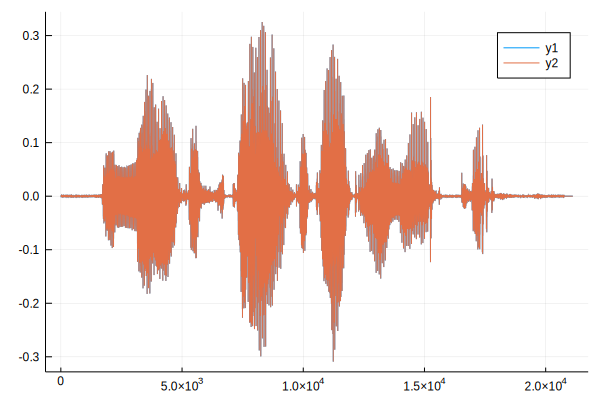

In [94]:
plot(idealSpeech)
plot!(cleanSpeech)

In [34]:
wavwrite(cleanSpeech, fs, "speech/cleaned_bar.wav")

In [41]:
rmθ

352×10 Matrix{Float64}:
 0.70595   -0.458142     0.518406    …   0.0084841    -0.000743727
 0.68546   -0.283167     0.305041       -0.0212928    -0.00728352
 0.47961   -0.123644     0.0958337       0.0146205    -0.0248405
 0.532991  -0.401142     0.53607         0.0790169    -0.036215
 0.692702  -0.490943     0.475441       -0.0178324    -0.00529141
 0.632515  -0.165737     0.425925    …  -0.0245883     0.0131599
 0.924646  -0.65777      0.618024       -0.0582087     0.0127209
 0.914904  -0.593504     0.635915        0.102058     -0.0510778
 0.700986  -0.223707     0.18866        -0.0120935     3.28068e-5
 0.467227   0.0901343    0.0640319      -0.00379038   -0.00520061
 0.728117  -0.251819     0.317259    …   0.000619148  -0.00821518
 0.520695  -0.121078     0.182195        0.0070287     0.0127972
 0.496393  -0.233929     0.236894       -0.00898863   -0.00707234
 ⋮                                   ⋱                
 0.928744  -0.371455    -1.83971e-5  …   0.0310943    -0.0568285
 0.6

In [42]:
inv.(rmγ)

352-element Vector{Float64}:
 3.377278808053442e-7
 3.1707373749582865e-7
 3.369838747378301e-7
 3.1476519665695923e-7
 3.311634762045135e-7
 3.3333781466687e-7
 3.231195466464152e-7
 3.241951676153243e-7
 3.1944824890213886e-7
 3.1211441480204415e-7
 3.148283177213206e-7
 3.143837843085827e-7
 3.107629056058924e-7
 ⋮
 3.886712511010483e-7
 3.682188164737988e-7
 3.3451173381940457e-7
 3.249535679937545e-7
 3.26079631051238e-7
 3.2547106539480255e-7
 3.239345345518389e-7
 3.0940579392953915e-7
 3.1312006564439425e-7
 3.119225408095454e-7
 3.179484081919775e-7
 3.2030291482503467e-7

In [ ]:
# clean speech
cb, fs = wavread("speech/bar_short.wav")

In [ ]:
# clean speech
cl, fs = wavread("speech/clean.wav")
cl = cl
# white noise
σ² = 1e-12
wn = sqrt(σ²)*randn(length(cl))
# noised speech
ns = cl .+ wn
# wavwrite(ns, fs, "speech/noised_bar.wav")
# ns, fs = wavread("speech/noised_bar.wav")